In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.animation as animation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


In [290]:
file_path = r"C:\Users\Lenovo\Downloads\Tuberculosis X-Ray Dataset (Synthetic)\tuberculosis_xray_dataset.csv"
df_original = pd.read_csv(file_path)



In [292]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4172 entries, 2 to 19994
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Age                  4172 non-null   float64 
 1   Gender               4172 non-null   int32   
 2   Chest_Pain           4172 non-null   int32   
 3   Cough_Severity       4172 non-null   float64 
 4   Breathlessness       4172 non-null   float64 
 5   Fatigue              4172 non-null   float64 
 6   Weight_Loss          4172 non-null   float64 
 7   Fever                4172 non-null   int32   
 8   Night_Sweats         4172 non-null   int32   
 9   Sputum_Production    4172 non-null   int32   
 10  Blood_in_Sputum      4172 non-null   int32   
 11  Smoking_History      4172 non-null   int32   
 12  Previous_TB_History  4172 non-null   int32   
 13  Class                4172 non-null   int32   
 14  Age_Group            0 non-null      category
dtypes: category(1), float64(5

In [294]:
print(df.columns) 


Index(['Age', 'Gender', 'Chest_Pain', 'Cough_Severity', 'Breathlessness',
       'Fatigue', 'Weight_Loss', 'Fever', 'Night_Sweats', 'Sputum_Production',
       'Blood_in_Sputum', 'Smoking_History', 'Previous_TB_History', 'Class',
       'Age_Group'],
      dtype='object')


In [296]:
# Drop unnecessary columns if they exist
if 'Patient_ID' in df.columns:
    df.drop(columns=['Patient_ID'], inplace=True)

# Handle missing values (apply median only to numeric columns)
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Convert data types if necessary
df['Age'] = df['Age'].astype(int)

# Encode categorical variables
categorical_cols = ['Gender', 'Chest_Pain', 'Fever', 'Night_Sweats', 'Sputum_Production',
                    'Blood_in_Sputum', 'Smoking_History', 'Previous_TB_History', 'Class']
label_encoders = {}
for col in categorical_cols:
    if df[col].dtype == 'object':  # Ensure only object-type columns are encoded
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Ensure 'Class' column is binary for modeling
df['Class'] = df['Class'].astype(int)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['Age', 'Cough_Severity', 'Breathlessness', 'Fatigue', 'Weight_Loss']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Define features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)  # Replace NaN values after conversion

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Train Logistic Regression model
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate models
def evaluate_model(name, y_true, y_pred):
    print(f"\nModel: {name}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))

# Print evaluation results
evaluate_model("Logistic Regression", y_test, y_pred_log)
evaluate_model("Random Forest", y_test, y_pred_rf)


Model: Logistic Regression
Accuracy: 0.5636
Precision: 0.5638
Recall: 0.5590
F1-score: 0.5614
              precision    recall  f1-score   support

           0       0.56      0.57      0.57       586
           1       0.56      0.56      0.56       585

    accuracy                           0.56      1171
   macro avg       0.56      0.56      0.56      1171
weighted avg       0.56      0.56      0.56      1171


Model: Random Forest
Accuracy: 0.7600
Precision: 0.7714
Recall: 0.7385
F1-score: 0.7546
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       586
           1       0.77      0.74      0.75       585

    accuracy                           0.76      1171
   macro avg       0.76      0.76      0.76      1171
weighted avg       0.76      0.76      0.76      1171



In [297]:
sns.set(style="darkgrid")

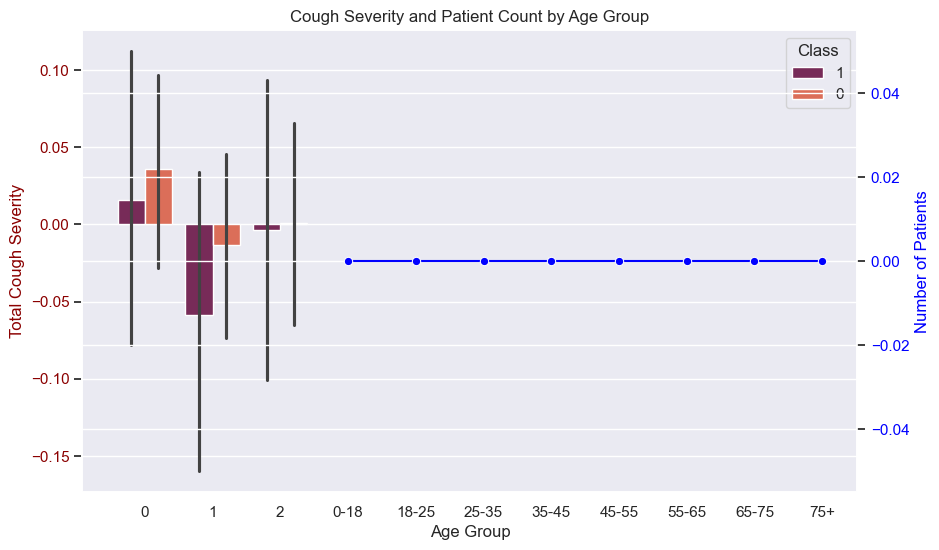

In [298]:
# Group data by age ranges
age_bins = [0, 18, 25, 35, 45, 55, 65, 75, 100]
age_labels = ["0-18", "18-25", "25-35", "35-45", "45-55", "55-65", "65-75", "75+"]
df['Age_Group'] = pd.cut(df['Age'] * scaler.scale_[0] + scaler.mean_[0], bins=age_bins, labels=age_labels)

# Aggregate data for bar and line plot
sum_cough_severity = df.groupby("Age_Group")["Cough_Severity"].sum()
count_samples = df["Age_Group"].value_counts().sort_index()

# Create figure and twin axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for sum of cough severity
sns.barplot(x=df['Smoking_History'], y=df['Weight_Loss'], hue=df['Class'].astype(str), palette="rocket", ax=ax1)
ax1.set_ylabel("Total Cough Severity", color="darkred")
ax1.set_xlabel("Age Group")
ax1.tick_params(axis='y', labelcolor="darkred")

# Create second y-axis
ax2 = ax1.twinx()
sns.lineplot(x=count_samples.index, y=count_samples.values, marker="o", color="blue", ax=ax2)
ax2.set_ylabel("Number of Patients", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# Titles and layout
plt.title("Cough Severity and Patient Count by Age Group")
plt.show()


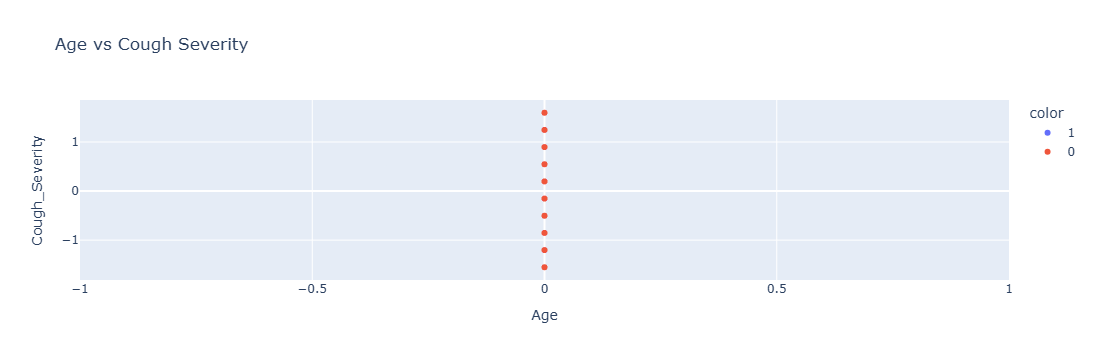

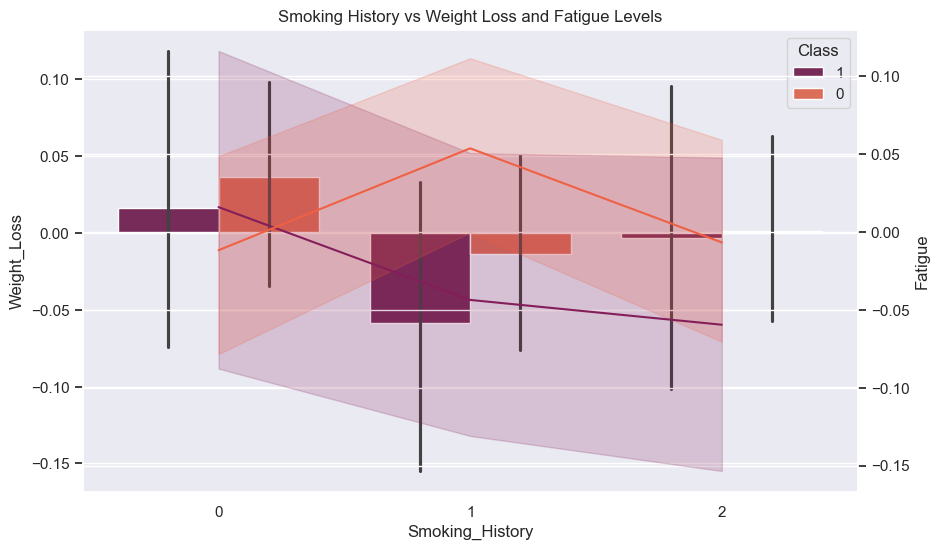

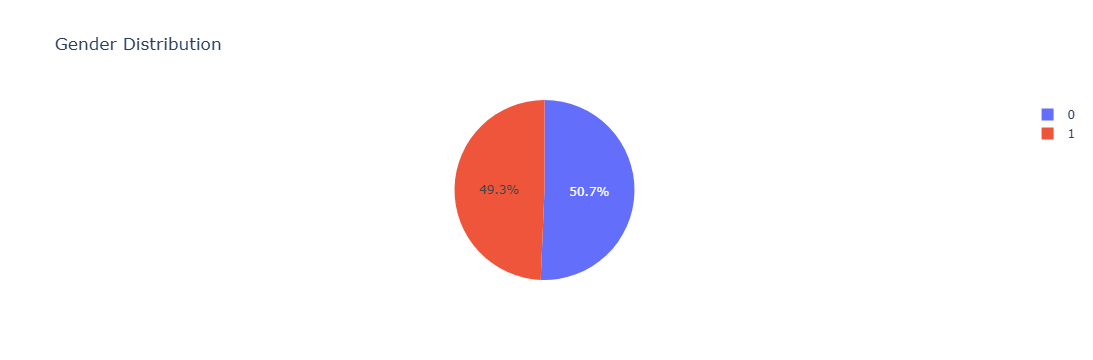

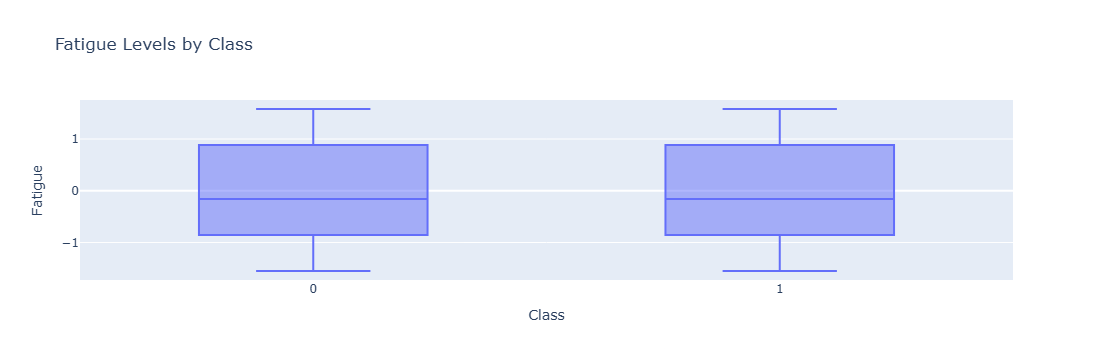

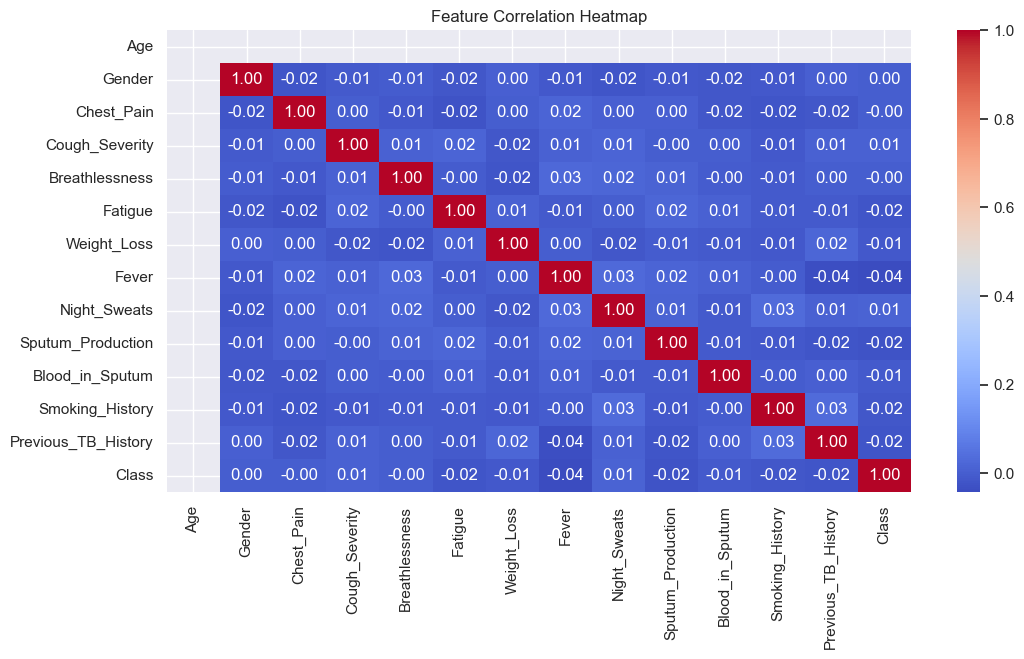

In [299]:
# Scatter Plot
fig = px.scatter(df, x='Age', y='Cough_Severity', color=df['Class'].astype(str), title="Age vs Cough Severity")
fig.show()

# Bar Chart with Line Chart Overlay
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=df['Smoking_History'], y=df['Weight_Loss'], hue=df['Class'].astype(str), palette="rocket", ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(x=df['Smoking_History'], y=df['Fatigue'], hue=df['Class'].astype(str), palette="rocket", ax=ax2, legend=False)
plt.title("Smoking History vs Weight Loss and Fatigue Levels")
plt.show()

# Pie Chart
fig = px.pie(df, names='Gender', title="Gender Distribution")
fig.show()

# Box Plot
fig = px.box(df, x='Class', y='Fatigue', title="Fatigue Levels by Class")
fig.show()

plt.figure(figsize=(12, 6))
numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


In [300]:

print(df.describe())
print(df.nunique())


          Age       Gender   Chest_Pain  Cough_Severity  Breathlessness  \
count  4172.0  4172.000000  4172.000000    4.172000e+03    4.172000e+03   
mean      0.0     0.493289     0.502397   -1.107030e-17    1.107030e-17   
std       0.0     0.500015     0.500054    1.000120e+00    1.000120e+00   
min       0.0     0.000000     0.000000   -1.552244e+00   -1.441427e+00   
25%       0.0     0.000000     0.000000   -8.528208e-01   -7.304275e-01   
50%       0.0     0.000000     1.000000   -1.533971e-01   -1.942808e-02   
75%       0.0     1.000000     1.000000    8.957384e-01    6.915714e-01   
max       0.0     1.000000     1.000000    1.595162e+00    1.402571e+00   

            Fatigue   Weight_Loss        Fever  Night_Sweats  \
count  4.172000e+03  4.172000e+03  4172.000000   4172.000000   
mean  -1.021874e-17 -9.367174e-18     1.015340      0.491611   
std    1.000120e+00  1.000120e+00     0.822691      0.499990   
min   -1.550420e+00 -1.735136e+00     0.000000      0.000000   
25% 


Training Logistic Regression Model...
Evaluating Logistic Regression Model...

Logistic Regression Model Performance:
Accuracy: 0.5636
Precision: 0.5638
Recall: 0.5590
F1-score: 0.5614
ROC-AUC: 0.5995
              precision    recall  f1-score   support

           0       0.56      0.57      0.57       586
           1       0.56      0.56      0.56       585

    accuracy                           0.56      1171
   macro avg       0.56      0.56      0.56      1171
weighted avg       0.56      0.56      0.56      1171



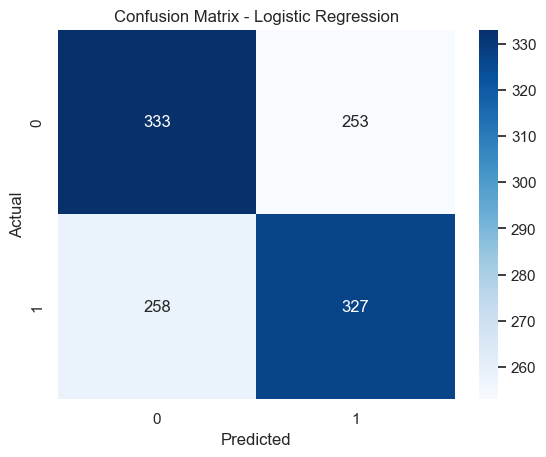


Training Random Forest Model...
Evaluating Random Forest Model...

Random Forest Model Performance:
Accuracy: 0.7600
Precision: 0.7714
Recall: 0.7385
F1-score: 0.7546
ROC-AUC: 0.8364
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       586
           1       0.77      0.74      0.75       585

    accuracy                           0.76      1171
   macro avg       0.76      0.76      0.76      1171
weighted avg       0.76      0.76      0.76      1171



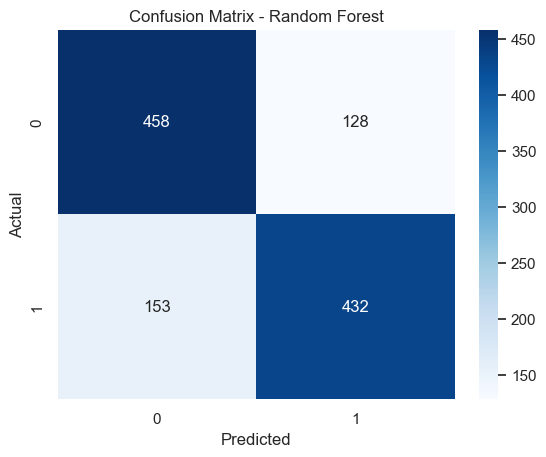


Training Gradient Boosting Model...
Evaluating Gradient Boosting Model...

Gradient Boosting Model Performance:
Accuracy: 0.7711
Precision: 0.8747
Recall: 0.6325
F1-score: 0.7341
ROC-AUC: 0.8038
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       586
           1       0.87      0.63      0.73       585

    accuracy                           0.77      1171
   macro avg       0.79      0.77      0.77      1171
weighted avg       0.79      0.77      0.77      1171



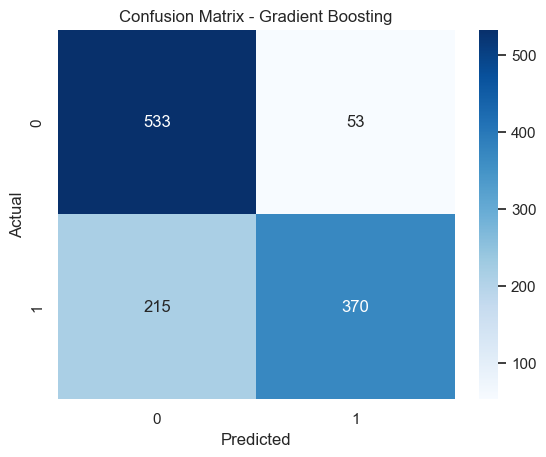


Training XGBoost Model...
Evaluating XGBoost Model...

XGBoost Model Performance:
Accuracy: 0.7754
Precision: 0.8815
Recall: 0.6359
F1-score: 0.7388
ROC-AUC: 0.8042
              precision    recall  f1-score   support

           0       0.72      0.91      0.80       586
           1       0.88      0.64      0.74       585

    accuracy                           0.78      1171
   macro avg       0.80      0.78      0.77      1171
weighted avg       0.80      0.78      0.77      1171



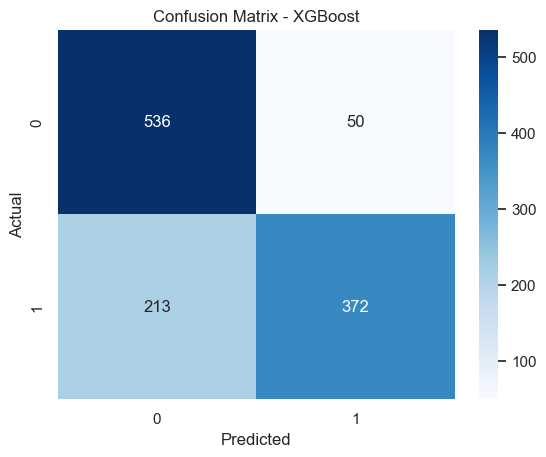


Training LightGBM Model...
[LightGBM] [Info] Number of positive: 2342, number of negative: 2341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 4683, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500107 -> initscore=0.000427
[LightGBM] [Info] Start training from score 0.000427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

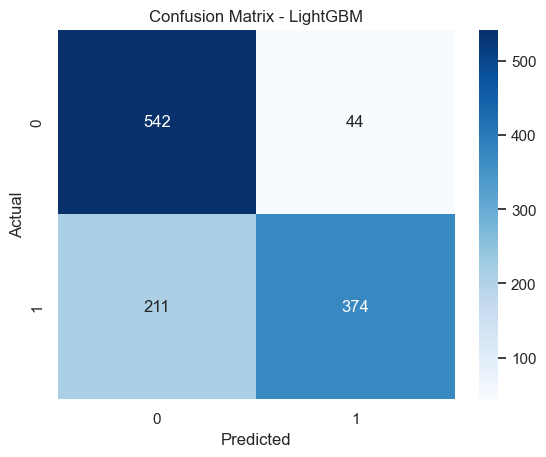


Training CatBoost Model...
Evaluating CatBoost Model...

CatBoost Model Performance:
Accuracy: 0.7805
Precision: 0.9205
Recall: 0.6137
F1-score: 0.7364
ROC-AUC: 0.8046
              precision    recall  f1-score   support

           0       0.71      0.95      0.81       586
           1       0.92      0.61      0.74       585

    accuracy                           0.78      1171
   macro avg       0.82      0.78      0.77      1171
weighted avg       0.82      0.78      0.77      1171



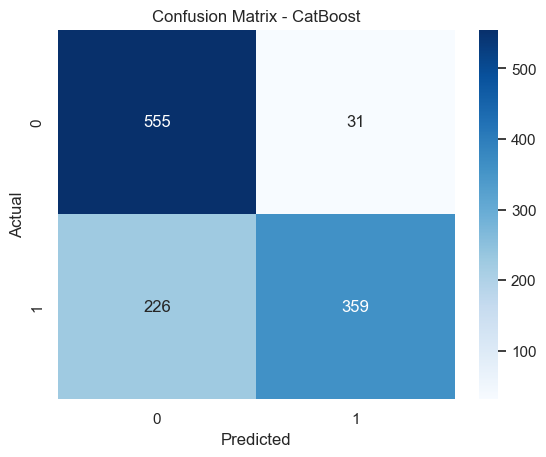


Training MLP Classifier Model...


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=300, learning_rate=0.05, depth=4, random_state=42, verbose=0),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=500)
}

# Train and Evaluate Models
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    print(f"\nTraining {name} Model...")
    model.fit(X_train, y_train)
    print(f"Evaluating {name} Model...")
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    
    print(f"\n{name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
    if y_pred_prob is not None:
        print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

for name, model in models.items():
    evaluate_model(name, model, X_train, X_test, y_train, y_test)

# Hyperparameter Tuning for XGBoost
print("\nPerforming Hyperparameter Tuning for XGBoost...")
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

random_search = RandomizedSearchCV(XGBClassifier(random_state=42), param_dist, cv=5, scoring='accuracy', n_jobs=-1, n_iter=5)
random_search.fit(X_train, y_train)

best_xgb = random_search.best_estimator_
print("\nBest Parameters for XGBoost:", random_search.best_params_)
evaluate_model("Best XGBoost", best_xgb, X_train, X_test, y_train, y_test)

# Feature Importance for XGBoost
plt.figure(figsize=(10, 6))
feature_importances = best_xgb.feature_importances_
sns.barplot(x=feature_importances, y=X.columns, palette='coolwarm')
plt.title("Feature Importance - XGBoost")
plt.show()
